In [80]:
%load_ext autoreload
%autoreload 2
%pylab inline

import itertools

import pandas as pd
from scipy.io import savemat, loadmat
import seaborn as sns
from sklearn.metrics import (log_loss, mean_squared_error, roc_curve, auc,
                             precision_recall_fscore_support, confusion_matrix)
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from BEKML import BEMKL
from utils import (plot_metrics, evaluate_model, poly_kernel, gauss_kernel,
                   scoring, DATA_CMAP, DATA_COLORS, DATA_MARKERS,
                   plot_e_a_mu, plot_kernel_importances,
                   plot_classification_report)


sns.set(style='ticks', context='talk')
np.set_printoptions(precision=4, linewidth=100, formatter={'float_kind': lambda x: f'{x:.4g}'})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
data = pd.read_csv('data/breast.csv', names=list(range(11)), index_col=0, na_values='?')
display(data.describe())
data = data.dropna()
display(data.head())
data.describe()

,1,2,3,4,5,6,7,8,9,10
count,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


,1,2,3,4,5,6,7,8,9,10
0,,,,,,,,,,
1000025,5,1,1,1,2,1.0,3,1,1,2
1002945,5,4,4,5,7,10.0,3,2,1,2
1015425,3,1,1,1,2,2.0,3,1,1,2
1016277,6,8,8,1,3,4.0,3,7,1,2
1017023,4,1,1,3,2,1.0,3,1,1,2


,1,2,3,4,5,6,7,8,9,10
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,2.699854
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.954592
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [3]:
X = data.iloc[:, :-1].values.copy()
y = data.iloc[:, -1].values.copy()
N, D = X.shape
y[y == 2] = -1
y[y == 4] = 1
X.shape, y.shape, y.mean()

((683, 9), (683,), -0.3001464128843338)

In [4]:
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=50)
X_2d = tsne.fit_transform(X)

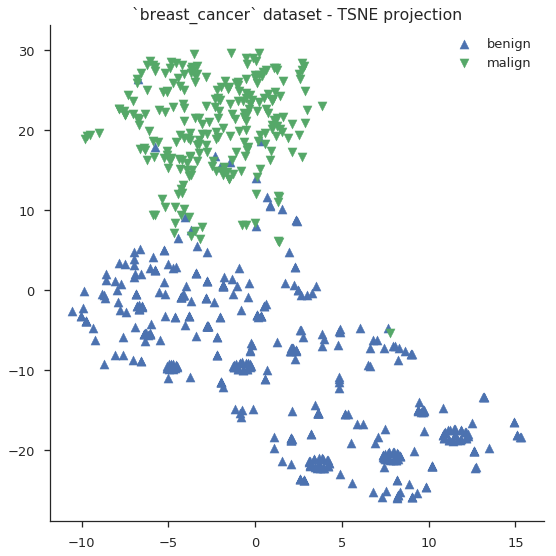

In [6]:
cmap = [(0.29803921568627451, 0.44705882352941179, 0.69019607843137254),
        (0.33333333333333331, 0.6588235294117647, 0.40784313725490196)]

ax = plt.figure(figsize=(8, 8)).gca()
ax.scatter(*X_2d[y == -1].T, c=DATA_COLORS[0], marker=DATA_MARKERS[0], label='benign')
ax.scatter(*X_2d[y == 1].T, c=DATA_COLORS[1], marker=DATA_MARKERS[1], label='malign')
ax.set_title('`breast_cancer` dataset - TSNE projection')
ax.legend()
sns.despine()
plt.tight_layout()

In [7]:
rbf_init, rbf_end = -3, 7
ply_init, ply_end = 1, 4

kernel_attrs = [('rbf', 'all', i) for i in range(rbf_init, rbf_end)]
kernels = [lambda A, B: gauss_kernel(A, B, 2**i)
           for i in range(rbf_init, rbf_end)]

kernel_attrs += [('poly', 'all', i) for i in range(ply_init, ply_end)]
kernels += [lambda A, B: poly_kernel(A, B, 1, i)
            for i in range(ply_init, ply_end)]

kernel_attrs += [('rbf', j, i) for i in range(rbf_init, rbf_end)
                 for j in range(D)]
kernels += [lambda A, B: gauss_kernel(A[:, j:j+1], B[:, j:j+1], 2**i)
            for i in range(rbf_init, rbf_end) for j in range(D)]

kernel_attrs += [('poly', j, i) for i in range(ply_init, ply_end)
                 for j in range(D)]
kernels += [lambda A, B: poly_kernel(A[:, j:j+1], B[:, j:j+1], 1, i)
            for i in range(ply_init, ply_end) for j in range(D)]
len(kernels), len(kernel_attrs)

(130, 130)

In [8]:
X_train, X_test, y_train, y_test =\
        train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [9]:
sparse_model = BEMKL(kernels=kernels, max_iter=200,
                     alpha_lambda=1, beta_lambda=1,
                     alpha_gamma=1, beta_gamma=1,
                     alpha_omega=1, beta_omega=1,
                     e_null_thrsh=1e-3, a_null_thrsh=1e-3,
                     filter_kernels=False, filter_sv=False,
                     verbose=10)
normalizer = Normalizer()
sparse_pipeline = make_pipeline(normalizer, sparse_model)
sparse_pipeline.fit(X_train, y_train)

Iter: 0. Bound: -1104404.3965411955
Iter: 10. Bound: -1327412.9613561928
Iter: 20. Bound: -1325660.0295160394
Iter: 30. Bound: -1323993.207318182
Iter: 40. Bound: -1322414.3321911248
Iter: 50. Bound: -1320912.368775877
Iter: 60. Bound: -1319453.3041269246
Iter: 70. Bound: -1318004.631635669
Iter: 80. Bound: -1316567.1357669986
Iter: 90. Bound: -1315182.188993112
Iter: 100. Bound: -1313841.3146169097
Iter: 110. Bound: -1312573.0134910864
Iter: 120. Bound: -1311265.2480116398
Iter: 130. Bound: -1309937.353162932
Iter: 140. Bound: -1308615.414843326
Iter: 150. Bound: -1307283.570502213
Iter: 160. Bound: -1305945.8460056572
Iter: 170. Bound: -1304571.5449406146
Iter: 180. Bound: -1303172.4129283156
Iter: 190. Bound: -1301765.6636738812


Pipeline(memory=None,
     steps=[('normalizer', Normalizer(copy=True, norm='l2')), ('bemkl', BEMKL(a_null_thrsh=0.001, alpha_gamma=1, alpha_lambda=1, alpha_omega=1,
   beta_gamma=1, beta_lambda=1, beta_omega=1, e_null_thrsh=0.001,
   filter_kernels=False, filter_sv=False, k_norm_type='kernel',
   kernels=[<function <listcomp...ambda> at 0x7f862a626c80>],
   margin=1, max_iter=200, random_state=None, sigma_g=0.1, verbose=10))])

In [10]:
X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)
Km_train, Km_norms = sparse_model._create_kernel_matrix(X_train_norm, X_train_norm)
X_norm = np.r_[X_train_norm, X_test_norm]
Km_test, _ = sparse_model._create_kernel_matrix(X_norm, X_norm, Km_norms)
train_len, _ = X_train.shape
Km_test = Km_test[:, train_len:, :train_len]

In [11]:
savemat('Km.mat', {
    'Km_train': Km_train.transpose(1, 2, 0),
    'y_train': y_train,
    'Km_test': Km_test.transpose(2, 1, 0),
    'y_test': y_test
})

In [68]:
predictions_mat = loadmat('prediction.mat')['prediction'][0, 0]
(predictions_mat['G']['mu'][0, 0].shape, predictions_mat['G']['sigma'][0, 0].shape,
 predictions_mat['f']['mu'][0, 0].shape, predictions_mat['f']['sigma'][0, 0].shape,
 predictions_mat['be']['mu'][0, 0].shape, predictions_mat['be']['sigma'][0, 0].shape,
 predictions_mat['a']['mu'][0, 0].shape, predictions_mat['a']['sigma'][0, 0].shape,
 predictions_mat['bounds'].shape, predictions_mat['p'].shape)

((130, 205),
 (130, 205),
 (205, 1),
 (205, 1),
 (131, 1),
 (131, 131),
 (478, 1),
 (478, 478),
 (200, 1),
 (205, 1))

In [69]:
y_pred_proba = sparse_pipeline.predict_proba(X_test_norm)
y_pred = sparse_pipeline.predict(X_test_norm)
y_pred_proba.shape, y_pred.shape

((205, 2), (205,))

In [70]:
display(log_loss(y_test, predictions_mat['p']),
        log_loss(y_test, y_pred_proba))
display(mean_squared_error(y_pred_proba[:, 1].flatten(), predictions_mat['p'].flatten()))

0.46647674383637538

0.47097404938304654

0.00081048901440524323

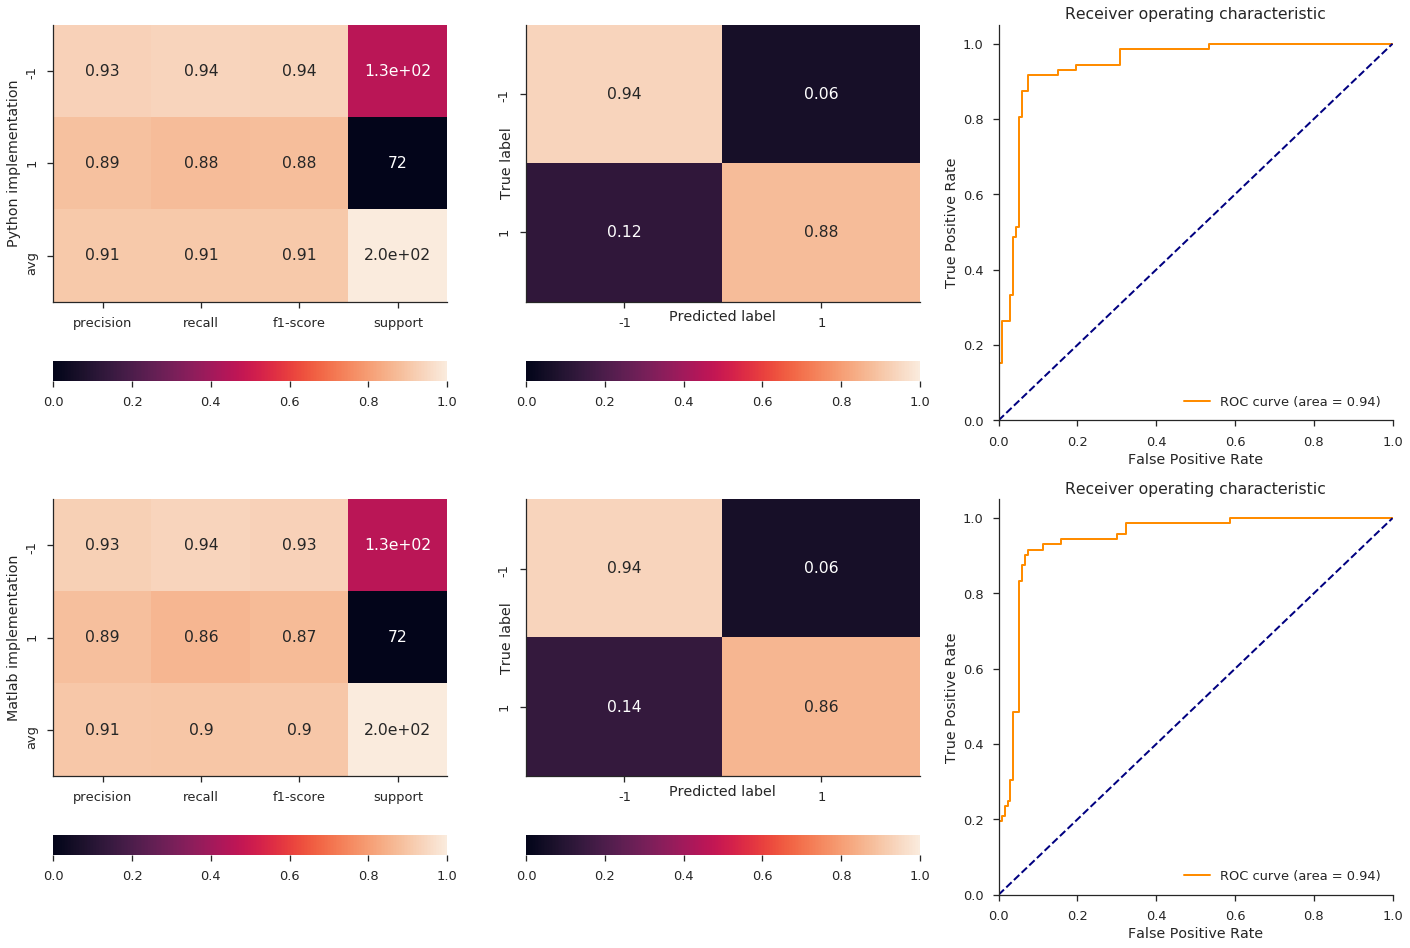

In [71]:
_, axes = plt.subplots(2, 3, figsize=(24, 16))
axes1, axes2 = axes

plot_metrics(y_test, y_pred, y_pred_proba[:, 1], axes=axes1,
             cbar_orient='horizontal')

y_pred_proba_mat = predictions_mat['p']
y_pred_mat = np.ones_like(y_pred_proba_mat)
y_pred_mat[y_pred_proba_mat < 0.5] = -1
plot_metrics(y_test, y_pred_mat, y_pred_proba_mat, axes=axes2,
             cbar_orient='horizontal')

ax1 = axes1[0]
ax2 = axes2[0]
ax1.set_ylabel('Python implementation')
ax2.set_ylabel('Matlab implementation')
sns.despine()

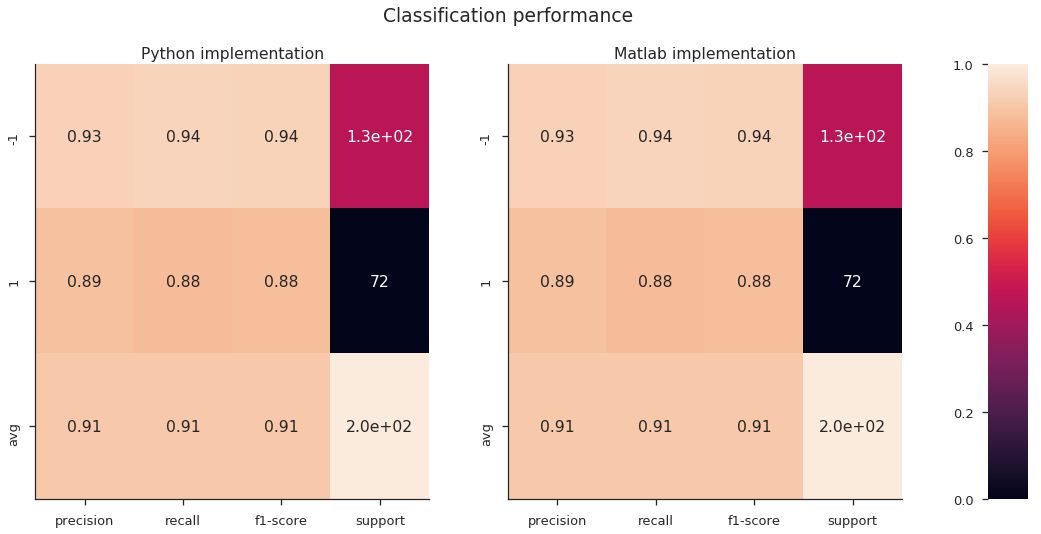

In [133]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
ax1, ax2, ax3 = axes.flatten()

plot_classification_report(y_test, y_pred, ax=ax1,
                           cbar=False)

y_pred_proba_mat = predictions_mat['p']
y_pred_mat = np.ones_like(y_pred_proba_mat)
y_pred_mat[y_pred_proba_mat < 0.5] = -1
plot_classification_report(y_test, y_pred, ax=ax2,
                           cbar_orient='vertical', cbar_ax=ax3)

ax1.set_title('Python implementation')
ax2.set_title('Matlab implementation')
ax1_pos = ax1.get_position()
ax2_pos = ax2.get_position()
ax3.set_position([ax2_pos.x1*1.08, ax2_pos.y0,
                  ax2_pos.width * 0.1, ax2_pos.height])
fig.suptitle('Classification performance', x=ax2_pos.x0)
sns.despine()

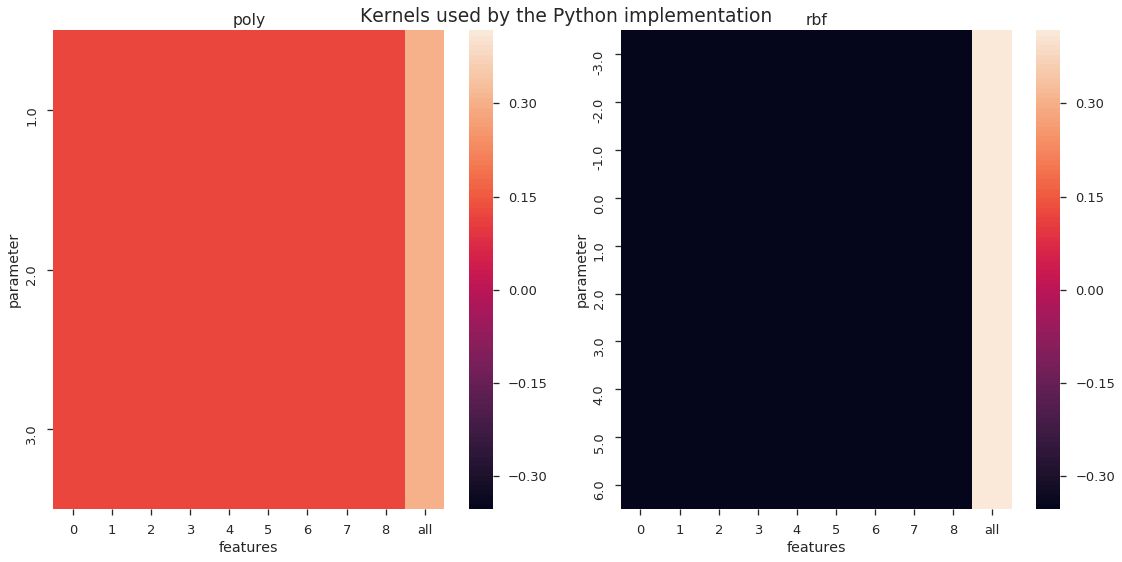

In [127]:
plot_kernel_importances(sparse_pipeline.named_steps['bemkl'].e_mu_orig,
                        kernel_attrs)
plt.suptitle('Kernels used by the Python implementation')
plt.tight_layout()

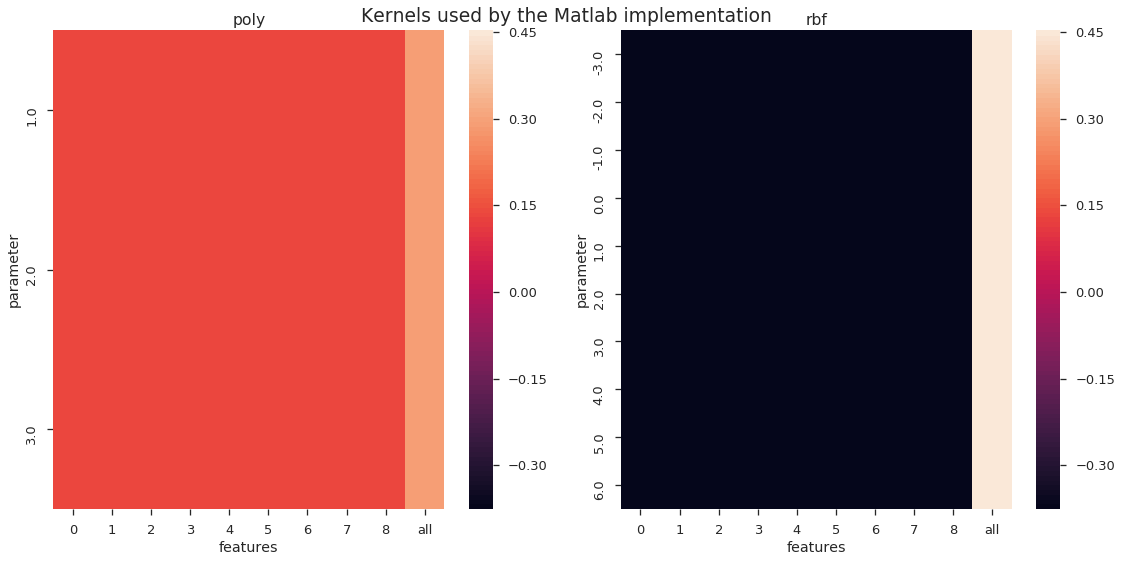

In [128]:
plot_kernel_importances(predictions_mat['be']['mu'][0, 0][1:, 0],
                        kernel_attrs)
plt.suptitle('Kernels used by the Matlab implementation')
plt.tight_layout()

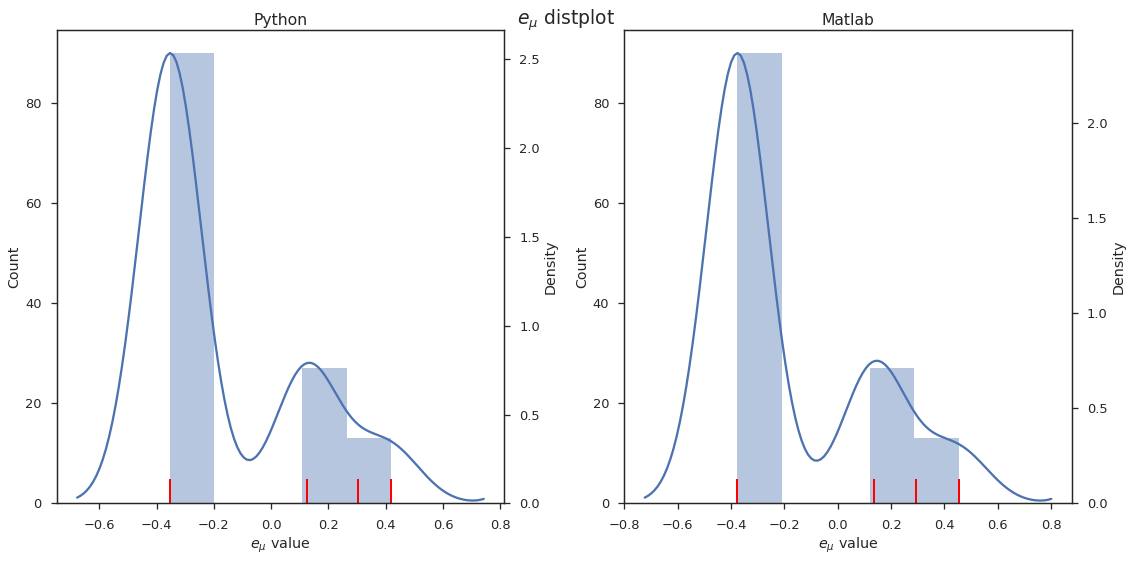

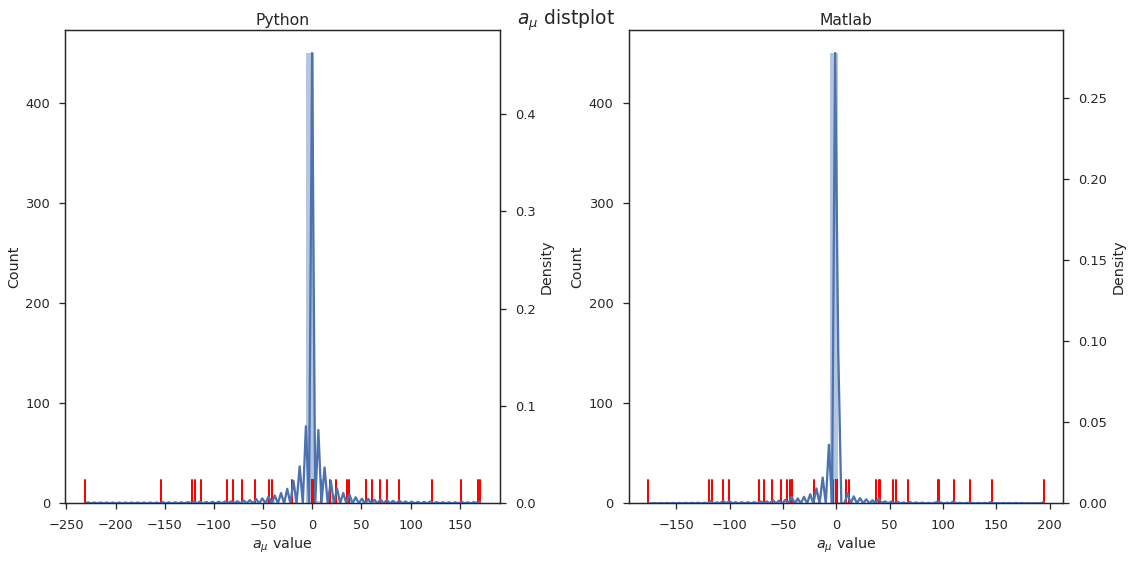

In [129]:
from BEKML import _plot_distplot

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ax1, ax2 = axes
sparse_model.plot_e(ax=ax1, rug=True,
                    rug_kws={'color': 'r', 'linewidth': 2,
                             'alpha': 1})
_plot_distplot(predictions_mat['be']['mu'][0, 0][1:, 0],
               r'$e_\mu$', alpha=0.3, ax=ax2, rug=True,
               rug_kws={'color': 'r', 'linewidth': 2,
                        'alpha': 1})
ax1.set_title('Python')
ax2.set_title('Matlab')
fig.suptitle(r'$e_\mu$ distplot')
plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ax1, ax2 = axes
sparse_model.plot_a(ax=ax1, rug=True,
                    rug_kws={'color': 'r', 'linewidth': 2,
                             'alpha': 1})
_plot_distplot(predictions_mat['a']['mu'][0, 0][:, 0],
               r'$a_\mu$', alpha=0.3, ax=ax2, rug=True,
               rug_kws={'color': 'r', 'linewidth': 2,
                        'alpha': 1})
ax1.set_title('Python')
ax2.set_title('Matlab')
fig.suptitle(r'$a_\mu$ distplot')
plt.tight_layout()

In [134]:
len(X_train)

478

In [131]:
e_mu_orig = sparse_pipeline.named_steps['bemkl'].e_mu_orig
e_null_thrsh = sparse_pipeline.named_steps['bemkl'].e_null_thrsh
e_nonull = e_mu_orig[np.abs(e_mu_orig) > e_null_thrsh]
print(len(e_nonull), e_null_thrsh)

a_mu_orig = sparse_pipeline.named_steps['bemkl'].a_mu_orig
a_null_thrsh = sparse_pipeline.named_steps['bemkl'].a_null_thrsh
a_nonull = a_mu_orig[np.abs(a_mu_orig) > a_null_thrsh]
print(len(a_nonull), a_null_thrsh)

130 0.001
476 0.001


In [132]:
e_mu_orig = predictions_mat['be']['mu'][0, 0][1:, 0]
e_nonull = e_mu_orig[np.abs(e_mu_orig) > e_null_thrsh]
print(len(e_nonull), e_null_thrsh)

a_mu_orig = predictions_mat['a']['mu'][0, 0][:, 0]
a_nonull = a_mu_orig[np.abs(a_mu_orig) > a_null_thrsh]
print(len(a_nonull), a_null_thrsh)

130 0.001
478 0.001


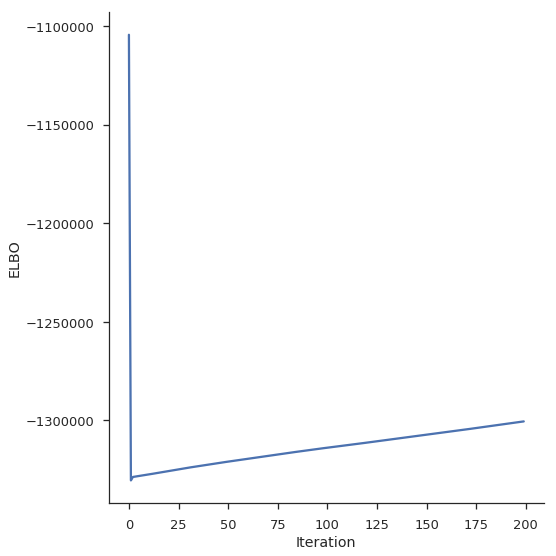

In [78]:
sparse_pipeline.named_steps['bemkl'].plot_bounds()
sns.despine()
plt.tight_layout()

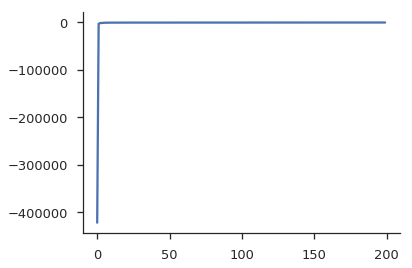

In [79]:
plt.plot(predictions_mat['bounds'].flatten())
sns.despine()
plt.tight_layout()